get_SARS-CoV-2_similarity

## Test pairwise alignment

In [1]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

In [5]:
seq1='''LDKSAGFPFNKWGKARLYYDSMSYEDQDALFAYTKRNVIPTITQMNLKYAISAKNRARTVAGVSICSTMTNRQFHQKLLKSIAATRGATVVIGTSKFYGGWHNMLKTVYSDVENPHLMGWDYPKCDRAMPNMLRIMASLVLARKHTTCCSLSHRFYRLANECAQVLSEMVMCGGSLYVKPGGTSSGDATTAYANSVFNICQAVTANVNALLSTDGNKIADKYVRNLQHRLYECLYRNRDVDTDFVNEFYAYLRKHFSMMILSDDAVVCFNSTYASQGLVASIKNFK
'''
seq1=seq1.replace('\n','')

In [6]:
seq2='''SSLGPSHEILRALKQDEVYGVLSMEVIEDLVKLAQETPLMFTTKVSAKFALTAKARARTIAACSMFASTLFRACHKPVTANIVNKSQSADLHSLIGVSKFYGNFDSYIKRRYGSLDNFKVFGSDYTKCDRSFPLVFRGLAAAVLYELGCWDSDNYLFINELQAFMLDFVLVGDAVYQKSGGTSSGDATTAFANTIYNHVVHLYVQLVTLVTEPVGIDQSVLKAAAVKLWQTGDSDVYDLLLDEVNGFDYCFNFLSDDSFILTRRDDGLLDIFNCVNFSRRLETLLHTKVDVTKAWQSDGIHEFCSSEIKQVDGVYQYVPDKNRILAAMLITGK
'''
seq2=seq2.replace('\n','')

In [7]:
from Bio import Align
aligner = Align.PairwiseAligner()
alignments = aligner.align(seq1, seq2)
alignment = alignments[0]

In [13]:
alignment.score

127.0

./diamond blastp -dnido-rdrp-reference \
-q sars_rdrp_hmm.fasta \
-o matches.tsv \
--id 0 \
--max-target-seqs 300 \
--header verbose \
--min-score 0 \
--query-cover 0 \
--subject-cover 0 \
--evalue 1 

In [12]:
print(alignment,file=open('xxxx.fasta','w'))

## get all rdrp

In [3]:
from typing import Generator,Tuple
def iter_match(genome_dict:dict)->Generator[Tuple[dict,dict],None,None]:
    for orf in genome_dict['results'][0]['openReadingFrames']:
        for match in orf['protein']['matches']:
            yield (orf,match)

In [33]:
from glob import glob
import json
o=[]
o_dict={}
b=0
for gfile in glob('nido_subset/*:genome.json'):
    # print('\n\n##'+gfile.split('/')[1].replace(':genome.json',''))
    genome_name=gfile.split('/')[1].replace(':genome.json','')
    genome_dict=json.load(open(gfile))
    genome_length=len(genome_dict['results'][0]['sequence'])
    for orf,match in iter_match(genome_dict):
        if match['signature']['accession']=='PF00680':
            seq=orf['protein']['sequence']
            if len(match['locations'])==1:
                _=match['locations'][0]
                b,e=_['start'],_['end']
                rdrp_seq=seq[b:e]
                rdrp_name=genome_name
                o.append(f'>{rdrp_name}\n{rdrp_seq}')
                o_dict[rdrp_name]=rdrp_seq
            else:
                for i,_ in enumerate(match['locations']):
                    b,e=_['start'],_['end']
                    rdrp_seq=seq[b:e]
                    rdrp_name=genome_name+'#'+str(i)
                    o.append(f'>{rdrp_name}\n{rdrp_seq}')
                    o_dict[rdrp_name]=rdrp_seq
            # orf_info=orf['start'],orf['end'],orf['strand']
    

In [25]:
print('\n'.join(o),file=open('nido-rdrp.fasta','w'))

In [42]:
import pandas as pd
head_lines=open('diamond-matches.tsv','r').readlines()[2].strip().split(': ')[1]
diamond_aligns=pd.read_csv('diamond-matches.tsv',skiprows=3,names=head_lines.split(', '),delim_whitespace=True)

In [43]:
diamond_aligns.columns

Index(['Query ID', 'Subject ID', 'Percentage of identical matches',
       'Alignment length', 'Number of mismatches', 'Number of gap openings',
       'Start of alignment in query', 'End of alignment in query',
       'Start of alignment in subject', 'End of alignment in subject',
       'Expected value', 'Bit score'],
      dtype='object')

In [52]:
fail_to_match=[i for i in o_dict.keys() if i not in diamond_aligns['Subject ID'].to_list()]

In [55]:
s_dict={}
ref_seq=o_dict['SARS-CoV-2||MN908947']
for i in fail_to_match:    
    query_seq=o_dict[i]
    aligner = Align.PairwiseAligner()
    alignments = aligner.align(query_seq, ref_seq)
    s_dict[i]=alignments[0].score
    
_=[(k,v) for k,v in s_dict.items()]
_.sort(key=lambda x:x[1],reverse=True)

In [74]:
with open('sort-rdrp.list','w') as f:
    f.write('id,match\n')
    for i,j in zip(diamond_aligns['Subject ID'],diamond_aligns['Percentage of identical matches']):
        f.write(i+','+f'{j:.2f}'+'\n')
    for i in _:
        f.write(i[0]+','+str(i[1])+'\n')  

ref seq:
SARS-CoV-2||MN908947

In [7]:
from Bio.Align.Applications import ClustalwCommandline
in_file = "nido-rdrp.fasta"
clustalw_cline = ClustalwCommandline("/home/hugheslab1/zfdeng/miniconda3/envs/rdrp/bin/clustalw2", infile=in_file,type='protein')
# o=clustalw_cline()

In [24]:
from Bio import Phylo
from Bio.Phylo import BaseTree
tree:BaseTree.Tree = Phylo.read("nido-rdrp.dnd", "newick")


In [31]:
Phylo.draw_ascii(tree,column_width=100)

  __ ACoV-WA3607||MK472070
 |
 |___ HipPBCoV-CHB25||MN611525
 |
 |                                                    _______ MYBV-1||KM110938
 |                                                 __|
 |                                                |  |_______ KKCBV||KT447550
 |                                                |
 |                                                |   ________ KRTGV-1||JX473849
 |                                                | _|
 |                                                || |________ DeBMAV||KP126831
 |                                                ||
 |                                                || _________ PBJV||KR139839
 |                                             ___|||
 |                                            |   | |________ SHFV||AF180391
 |                                            |   |
 |                                            |   | __________ KRCV-1||KC787630
 |                                            |   ,|
 |       

In [9]:
type(tree)

Bio.Phylo.Newick.Tree

In [30]:
tree.rooted

False

In [18]:
def get_x_positions(tree:BaseTree.Tree):
        """Create a mapping of each clade to its horizontal position.

        Dict of {clade: x-coord}
        """
        depths = tree.depths()
        # If there are no branch lengths, assume unit branch lengths
        if not max(depths.values()):
            depths = tree.depths(unit_branch_lengths=True)
        return depths
    
def get_y_positions(tree:BaseTree.Tree):
    """Create a mapping of each clade to its vertical position.

    Dict of {clade: y-coord}.
    Coordinates are negative, and integers for tips.
    """
    maxheight = tree.count_terminals()
    # Rows are defined by the tips
    heights = {
        tip: maxheight - i for i, tip in enumerate(reversed(tree.get_terminals()))
    }

    # Internal nodes: place at midpoint of children
    def calc_row(clade):
        for subclade in clade:
            if subclade not in heights:
                calc_row(subclade)
        # Closure over heights
        heights[clade] = (
            heights[clade.clades[0]] + heights[clade.clades[-1]]
        ) / 2.0

    if tree.root.clades:
        calc_row(tree.root)
    return heights

In [26]:
import math
column_width=80
taxa = tree.get_terminals()
    # Some constants for the drawing calculations
max_label_width = max(len(str(taxon)) for taxon in taxa)
drawing_width = column_width - max_label_width - 1
def get_col_positions(tree:BaseTree.Tree):
    """Create a mapping of each clade to its column position."""
    depths = tree.depths()
    # If there are no branch lengths, assume unit branch lengths
    if max(depths.values()) == 0:
        depths = tree.depths(unit_branch_lengths=True)
    # Potential drawing overflow due to rounding -- 1 char per tree layer
    fudge_margin = int(math.ceil(math.log(len(taxa), 2)))
    cols_per_branch_unit = (drawing_width - fudge_margin) / max(depths.values())
    return {
        clade: int(blen * cols_per_branch_unit + 1.0)
        for clade, blen in depths.items()
    }

In [27]:
get_col_positions(tree)

{Clade(): 1,
 Clade(branch_length=0.00344): 1,
 Clade(branch_length=0.0454, name='ACoV-WA3607||MK472070'): 3,
 Clade(branch_length=0.05138, name='HipPBCoV-CHB25||MN611525'): 3,
 Clade(branch_length=0.00394): 1,
 Clade(branch_length=0.00541): 1,
 Clade(branch_length=0.02555): 2,
 Clade(branch_length=0.0187): 3,
 Clade(branch_length=0.00299): 3,
 Clade(branch_length=0.01125): 4,
 Clade(branch_length=0.05637): 7,
 Clade(branch_length=0.02268): 8,
 Clade(branch_length=0.03857): 10,
 Clade(branch_length=0.02676): 12,
 Clade(branch_length=0.11684): 18,
 Clade(branch_length=0.03342): 20,
 Clade(branch_length=0.04776): 22,
 Clade(branch_length=0.02632): 24,
 Clade(branch_length=0.03556): 25,
 Clade(branch_length=0.04042): 28,
 Clade(branch_length=0.04908): 30,
 Clade(branch_length=0.00646): 30,
 Clade(branch_length=0.01979): 32,
 Clade(branch_length=0.05142): 34,
 Clade(branch_length=0.00848): 35,
 Clade(branch_length=0.03595): 37,
 Clade(branch_length=0.10062, name='MYBV-1||KM110938'): 42,
 C

In [21]:
x_pos,y_pos=get_x_positions(tree),get_y_positions(tree)

In [22]:
x,y=[],[]
for k in x_pos.keys():
    x.append(x_pos[k])
    y.append(y_pos[k])

<Axes: >

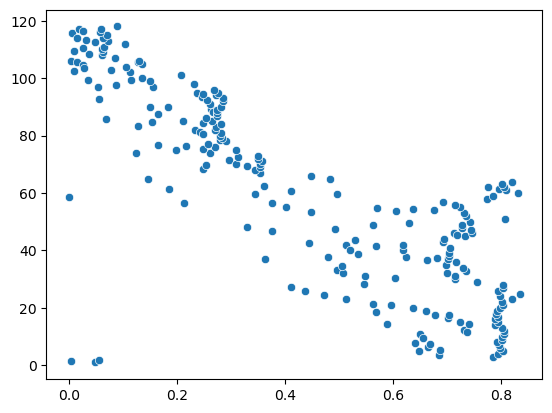

In [23]:
import seaborn as sns
sns.scatterplot(x=x,y=y)